In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GrokkingModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GrokkingModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out





In [12]:
def train_model(model, criterion, optimizer, data_loader, num_epochs):
    for epoch in range(num_epochs):
        for inputs, targets in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


def create_modular_addition_dataset(modulus):
    data = []
    targets = []
    num_samples=modulus**2
    for x in range(modulus):
        for y in range(modulus):
            z = (x + y) % modulus
            x_oh = F.one_hot(torch.tensor(x), num_classes=modulus)
            y_oh = F.one_hot(torch.tensor(y), num_classes=modulus)
            data.append(torch.cat([x_oh, y_oh]).float())
            targets.append(torch.tensor(z, dtype=torch.long))
    return torch.stack(data), torch.stack(targets)

def evaluate(model, loader, criterion, device):
    model.eval()
    correct = total = 0
    loss_sum = 0.0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)
            loss_sum += loss.item()

            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return loss_sum / len(loader), correct / total



from torch.utils.data import DataLoader, TensorDataset,random_split
modulus = 11
data, targets = create_modular_addition_dataset(modulus)
dataset = TensorDataset(data, targets)

train_size = 96
test_size = 25
g = torch.Generator().manual_seed(0)
train_ds, test_ds = random_split(dataset, [train_size, test_size], generator=g)

train_loader = DataLoader(train_ds, batch_size=train_size, shuffle=True)  # full batch
test_loader  = DataLoader(test_ds,  batch_size=test_size,  shuffle=False)

if torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

model = GrokkingModel(input_size=2*modulus, hidden_size=256, output_size=modulus)
model.to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=3e-2)

In [13]:
train_accuracies = []
test_accuracies = []
steps = []

eval_every = 1000

for step in range(800000):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    if (step + 1) % eval_every == 0:
        tr_loss, tr_acc = evaluate(model, train_loader, criterion, device)
        te_loss, te_acc = evaluate(model, test_loader, criterion, device)
        steps.append(step + 1)
        train_accuracies.append(tr_acc)
        test_accuracies.append(te_acc)
        print(step + 1, tr_acc, te_acc, tr_loss, te_loss)


1000 1.0 0.0 0.3294559419155121 6.068700313568115
2000 1.0 0.0 0.29428011178970337 4.064181804656982
3000 1.0 0.0 0.29085615277290344 3.3239569664001465
4000 1.0 0.0 0.28991544246673584 3.1037724018096924
5000 1.0 0.0 0.2896297574043274 2.9994213581085205
6000 1.0 0.0 0.2895762324333191 2.951460838317871
7000 1.0 0.0 0.2895708382129669 2.929448366165161
8000 1.0 0.0 0.2895704209804535 2.915714740753174
9000 1.0 0.0 0.2895703613758087 2.9038288593292236
10000 1.0 0.0 0.28957033157348633 2.892347812652588
11000 1.0 0.0 0.28957033157348633 2.881199598312378
12000 1.0 0.0 0.2895703613758087 2.870116949081421
13000 1.0 0.0 0.28957033157348633 2.8591461181640625
14000 1.0 0.0 0.2895703911781311 2.848540782928467
15000 1.0 0.0 0.2895703613758087 2.838850498199463
16000 1.0 0.0 0.2895703613758087 2.830012559890747
17000 1.0 0.0 0.2895703911781311 2.8224716186523438
18000 1.0 0.0 0.2895704209804535 2.8150365352630615
19000 1.0 0.0 0.28957033157348633 2.8084003925323486
20000 1.0 0.0 0.289570361

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, 'grokking_modular_addition.pth')


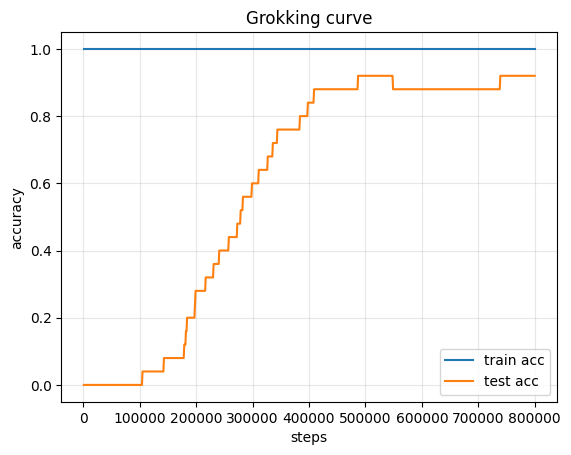

In [26]:

import matplotlib.pyplot as plt
steps = [(i+1)*eval_every for i in range(len(test_accuracies))]


plt.figure()
plt.plot(steps, train_accuracies, label="train acc")
plt.plot(steps, test_accuracies, label="test acc")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.ylim(-0.05, 1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.title("Grokking curve")
plt.show()

## What is this experiment showing?

This model is trained on modular addition: given two numbers `x` and `y`, it should predict `(x + y) mod 11`.

The important part is when it learns the rule.

- Very early, the model gets 100% training accuracy (it memorizes the examples it sees).
- For a long time, it fails on unseen examples.
- Much later, without changing the data, it suddenly starts getting unseen examples right.

This delayed jump in generalization is called grokking (https://arxiv.org/abs/2201.02177).


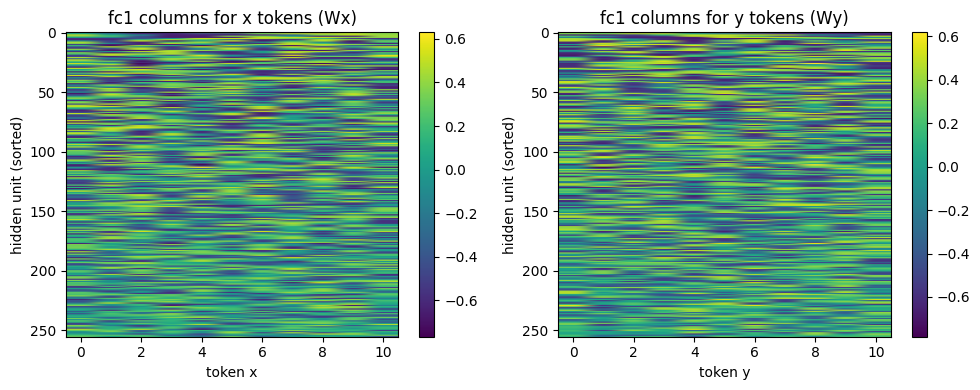

In [ ]:
def plot_fc1_token_heatmaps(model, modulus):
    W1 = model.fc1.weight.detach().cpu()   # (H, 2m)
    H = W1.shape[0]
    Wx = W1[:, :modulus]                   # (H, m)
    Wy = W1[:, modulus:2*modulus]          # (H, m)

    score = (Wx.abs().mean(dim=1) + Wy.abs().mean(dim=1))
    order = torch.argsort(score, descending=True)
    Wx = Wx[order]
    Wy = Wy[order]

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(Wx, aspect="auto")
    plt.colorbar()
    plt.title("fc1 columns for x tokens (Wx)")
    plt.xlabel("token x")
    plt.ylabel("hidden unit (sorted)")

    plt.subplot(1, 2, 2)
    plt.imshow(Wy, aspect="auto")
    plt.colorbar()
    plt.title("fc1 columns for y tokens (Wy)")
    plt.xlabel("token y")
    plt.ylabel("hidden unit (sorted)")

    plt.tight_layout()
    plt.show()

plot_fc1_token_heatmaps(model, modulus=11)



## Why do the weight plots look messy?

The first-layer weight plots (heatmaps) show raw internal numbers of the model.
These numbers are *not meant to be human-readable*.

Hidden neurons can:
- be reordered
- be rotated
- flip signs
without changing what the model does.

So we should not expect to see clean patterns like “counting” or “circles” in raw weights.

Instead, these plots are mainly useful to check that:
- nothing is exploding
- nothing collapsed to zero

The *meaningful structure* shows up in how the model behaves, not in individual weights.


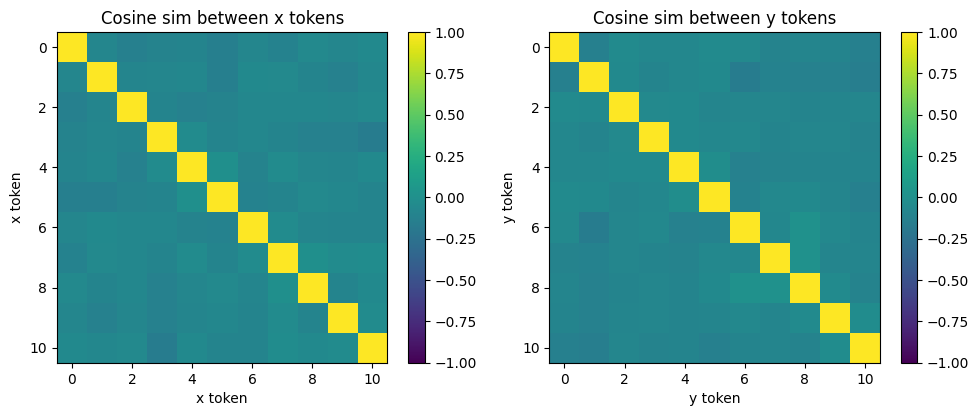

In [27]:
def cosine_sim_matrix(M):  
    M = M - M.mean(dim=0, keepdim=True)
    M = M / (M.norm(dim=0, keepdim=True) + 1e-8)
    return (M.T @ M).clamp(-1, 1)          # (m, m)

def plot_token_cosine_sims(model, modulus):
    W1 = model.fc1.weight.detach().cpu()
    Wx = W1[:, :modulus]
    Wy = W1[:, modulus:2*modulus]

    Sx = cosine_sim_matrix(Wx)
    Sy = cosine_sim_matrix(Wy)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(Sx, vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Cosine sim between x tokens")
    plt.xlabel("x token")
    plt.ylabel("x token")

    plt.subplot(1, 2, 2)
    plt.imshow(Sy, vmin=-1, vmax=1)
    plt.colorbar()
    plt.title("Cosine sim between y tokens")
    plt.xlabel("y token")
    plt.ylabel("y token")

    plt.tight_layout()
    plt.show()

plot_token_cosine_sims(model, modulus=11)


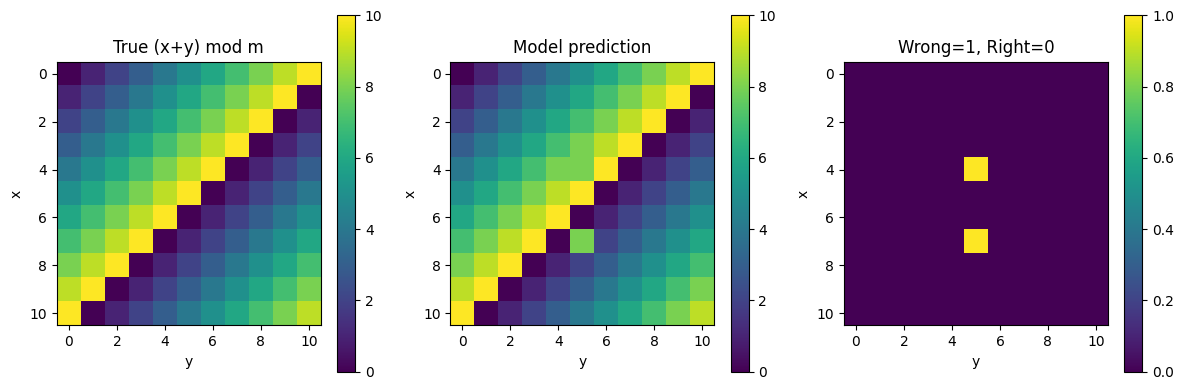

In [ ]:
def plot_addition_tables(model, modulus, device):
    model.eval()
    xs, ys, inputs, targets = [], [], [], []
    for x in range(modulus):
        for y in range(modulus):
            z = (x + y) % modulus
            x_oh = torch.nn.functional.one_hot(torch.tensor(x), num_classes=modulus)
            y_oh = torch.nn.functional.one_hot(torch.tensor(y), num_classes=modulus)
            inp = torch.cat([x_oh, y_oh]).float()
            inputs.append(inp)
            targets.append(z)
            xs.append(x); ys.append(y)

    X = torch.stack(inputs).to(device)
    y_true = torch.tensor(targets, dtype=torch.long).to(device)

    with torch.no_grad():
        logits = model(X)
        y_pred = logits.argmax(dim=1)

    pred_table = y_pred.detach().cpu().view(modulus, modulus)
    true_table = y_true.detach().cpu().view(modulus, modulus)
    wrong = (pred_table != true_table).int()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(true_table, aspect="equal")
    plt.colorbar()
    plt.title("True (x+y) mod m")
    plt.xlabel("y"); plt.ylabel("x")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_table, aspect="equal")
    plt.colorbar()
    plt.title("Model prediction")
    plt.xlabel("y"); plt.ylabel("x")

    plt.subplot(1, 3, 3)
    plt.imshow(wrong, aspect="equal")
    plt.colorbar()
    plt.title("Wrong=1, Right=0")
    plt.xlabel("y"); plt.ylabel("x")

    plt.tight_layout()
    plt.show()

plot_addition_tables(model, modulus=11, device=device)


## Why the addition table is the key plot

The addition table directly shows what the model predicts for **every possible (x, y) pair**.

- The true table has a diagonal wrap-around pattern (this is modular addition).
- The model’s table matches this pattern almost perfectly.
- Only two cells are wrong, both near the wrap-around boundary.

This tells us:
- the model learned the **rule**, not just memorized examples
- the remaining errors are edge cases, not random failures

Even though the weights look messy, the **function learned by the model is clearly structured**.
That’s the core evidence of grokking.



## What does this tell us about how the model works?

This experiment does not explain the model by pointing to individual neurons or weights.
Instead, it explains the model by showing **how learning unfolds over time**.

Early in training, the model finds solutions that fit the training data but do not generalize.
These solutions are easy to reach and do not require learning the underlying rule.

Later, because of weight decay and continued optimization, these brittle solutions become unstable.
The model is slowly pushed toward representations that are simpler and more regular.

When the internal representation reorganizes enough, the correct global rule
(modular addition) suddenly becomes the easiest solution to maintain.
This moment is what we observe as grokking.


## Why this is called “one of the most advanced models we understand”

We do not understand this model because we can inspect a weight matrix and read off the algorithm.

We understand it because we can explain:
- why memorization happens before generalization
- why regularization is necessary for the rule to emerge
- why generalization appears suddenly rather than gradually
- why the learned behavior is global and structured

In most modern models, we can observe *what* happens.
In this case, we can explain *why* it happens.

That is what makes this one of the most well-understood learning phenomena we have.
